# Process scans of death records of Curaçao

## 1. Count scans

In [1]:
import os
import re

In [2]:
data_dir = "../../data/Overlijden"

In [3]:
def count_files(dir_name):
    return len([file_name for file_name in os.listdir(dir_name)
                          if re.search("\.jpg$", file_name, re.IGNORECASE)])

In [4]:
def get_year_from_dir_name(dir_name):
    return int(re.sub("^.*(\d{4})$", "\\1", dir_name))

In [5]:
def count_scans(dir_name):
    counts = []
    for year_dir in sorted(os.listdir(dir_name)):
        if re.search("^O\.R\. \d{4}$", year_dir):
            outside_count = 0
            city_count = 0
            for scan_dir in os.listdir(os.path.join(data_dir, year_dir)):
                scan_dir = os.path.join(data_dir, year_dir, scan_dir)
                if os.path.isdir(scan_dir):
                    if re.search("buiten", scan_dir, re.IGNORECASE):
                        outside_count += count_files(scan_dir)
                    elif re.search("stad", scan_dir, re.IGNORECASE):
                        city_count += count_files(scan_dir)
            counts.append((get_year_from_dir_name(year_dir), city_count, outside_count))
    return counts

In [6]:
def get_total(counts):
    return sum( [ int(x[2]) + int(x[1]) for x in counts ] )

In [7]:
counts = count_scans(data_dir)

In [8]:
get_total(counts)

72292

## 2. Check counts

In [9]:
def print_with_color(string, color_code=1):
    print(f"\x1b[3{color_code}m{string}\x1b[m", end="")

In [10]:
def get_min_max_counts(counts):
    if not counts:
        return None, None
    else:
        years = [data[0] for data in counts]
        return min(years), max(years)

In [11]:
def check_and_fill_gaps(counts):
    min_count, max_count = get_min_max_counts(counts)
    years = [data[0] for data in counts]
    for year in range(min_count, max_count+1):
        if year not in years:
            print_with_color(f"warning: missing year: {year}")
            counts.append((year, 0, 0))
    return counts

In [12]:
def check_duplicates_counts(counts):
    seen = {}
    for data in counts:
        year = data[0]
        if year in seen:
            print_with_color(f"warning: duplicate year: {year} {seen}")
        seen[year] = True

In [13]:
def check_zero_counts(counts):
    for data in counts:
        if data[1] == 0:
            print_with_color(f"warning: no scans for stad in year {data[0]}")
        if data[2] == 0:
            print_with_color(f"warning: no scans for buiten in year {data[0]}")

In [14]:
def check_counts(counts):
    check_duplicates_counts(counts)
    check_zero_counts(counts)
    counts = check_and_fill_gaps(counts)
    return counts

In [15]:
counts = check_counts(counts)

## 3. Check file names

In [16]:
def check_year_dir_names(data_dir):
    for year_dir_name in sorted(os.listdir(data_dir)):
        if not os.path.isdir(os.path.join(data_dir, year_dir_name)):
            print_with_color(f"\"{year_dir_name}\" is not a directory!\n")
        elif not re.search("^O\.R\. \d\d\d\d$", year_dir_name):
            print_with_color(f"the name of \"{year_dir_name}\" is not shaped like a year directory name!\n")
        else:
            check_district_dir_names(data_dir, year_dir_name)

In [17]:
def check_district_dir_names(data_dir, year_dir_name):
    for district_dir_name in sorted(os.listdir(os.path.join(data_dir, year_dir_name))):
        if district_dir_name == "log.txt":
            continue
        if not os.path.isdir(os.path.join(data_dir, year_dir_name, district_dir_name)):
            print_with_color(f"\"{district_dir_name}\" is not a directory!\n")
        elif (not re.search("^O\.R\. \d\d\d\d Stad$", district_dir_name) and
            not re.search("^O\.R\. \d\d\d\d Buiten \d\d?e distr$", district_dir_name) and
            not re.search("^O\.R\. \d\d\d\d Buiten (Midden|Oost|West) \de distr", district_dir_name)):
            print_with_color(f"the name of \"{district_dir_name}\" is not shaped like a district directory name! (in {year_dir_name})\n")
        else:
            check_scan_file_names(data_dir, year_dir_name, district_dir_name)

In [18]:
def check_scan_file_names(data_dir, year_dir_name, district_dir_name):
    for scan_file_name in sorted(os.listdir(os.path.join(data_dir, year_dir_name, district_dir_name))):
        if not os.path.isfile(os.path.join(data_dir, year_dir_name, district_dir_name, scan_file_name)):
            print_with_color(f"\"{scan_file_name}\" is not a file!\n")
        elif (not re.search("^O\.R\. \d\d\d\d Stad \d\d\d.JPG$", scan_file_name) and
              not re.search("^O\.R\. \d\d\d\d Buiten \d\d?e distr\. \d\d\d.JPG$", scan_file_name) and
              not re.search("^O\.R\. \d\d\d\d Buiten (Midden|Oost|West) \de distr\. \d\d\d.JPG$", scan_file_name)):
            print_with_color(f"the name of \"{scan_file_name}\" is not shaped like a scan file name!\n")

In [19]:
check_year_dir_names(data_dir)

the name of "renamed" is not shaped like a district directory name! (in O.R. 1848)
the name of "renamed" is not shaped like a district directory name! (in O.R. 1849)
the name of "renamed" is not shaped like a district directory name! (in O.R. 1850)
the name of "renamed" is not shaped like a district directory name! (in O.R. 1851)
the name of "O.R. 1859 Gr" is not shaped like a district directory name! (in O.R. 1859)
the name of "O.R. 1870 Stad 2e exenplaar" is not shaped like a district directory name! (in O.R. 1870)
the name of "O.R. 1887 1e deel Stad & Buiten" is not shaped like a district directory name! (in O.R. 1887)
the name of "O.R. 1887 2e deel Stad & Buiten" is not shaped like a district directory name! (in O.R. 1887)
the name of "O.R. 1887 Buiten 2e distr2" is not shaped like a district directory name! (in O.R. 1887)
the name of "O.R. 1887 Buiten 3e distr2" is not shaped like a district directory name! (in O.R. 1887)
the name of "O.R. 1887 Buiten 4e distr2" is not shaped like

## 4. Visualize counts

In [20]:
import matplotlib.pyplot as plt

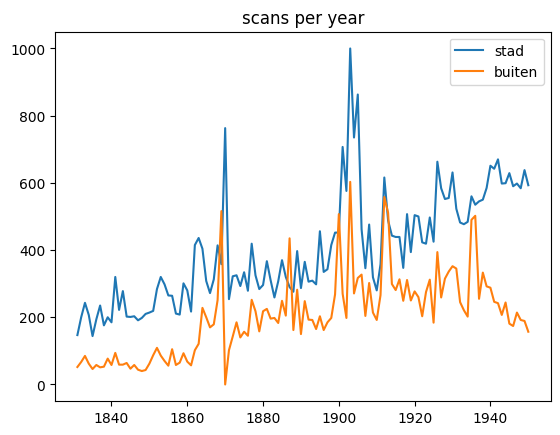

In [21]:
plt.title("scans per year")
plt.plot([x[0] for x in counts], [x[1] for x in counts], label="stad")
plt.plot([x[0] for x in counts], [x[2] for x in counts], label="buiten")
plt.legend()
plt.show()